<a href="https://colab.research.google.com/github/casangi/cngi_prototype/blob/master/docs/imaging/imaging_weights_example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imaging Weights

This notebook will demonstrate how to create images with different imaging weighting schemes (natural, uniform, briggs) and how to make use of the ```storage_parms``` to append images.

For this demonstration data from the ALMA First Look at Imaging CASAguide (https://casaguides.nrao.edu/index.php/First_Look_at_Imaging) will be used. The measurement set has been converted to vis.zarr (using convert_ms in cngi.conversion)

This walkthrough is designed to be run in a Jupyter notebook on Google Colaboratory. To open the notebook in colab, go [here](https://colab.research.google.com/github/casangi/cngi_prototype/blob/master/docs/imaging/imaging_weights_example.ipynb).

## Installation and Dataset Download


In [ ]:
import os
os.system("pip install --extra-index-url https://test.pypi.org/simple/ cngi-prototype==0.0.68")

#sis14_twhya_field_5_lsrk_pol_xx.vis.zarr.zip https://drive.google.com/file/d/1PNL0ANqnN7eyYOpQ_vMslQlorUhtrUmE/view?usp=sharing
id = '1PNL0ANqnN7eyYOpQ_vMslQlorUhtrUmE'
os.system('curl -c ./cookie -s -L "https://drive.google.com/uc?export=download&id=%s"' % id)
os.system('curl -Lb ./cookie "https://drive.google.com/uc?export=download&confirm=`awk \'/download/ {print $NF}\' ./cookie`&id=%s" -o vis.zarr.zip' % id)
os.system('unzip vis.zarr.zip')
print('complete')

complete


## Load Dataset

For an explanation of how the vis.zarr file was created and the chunking go to the [continuum image example](https://cngi-prototype.readthedocs.io/en/latest/prototypes/continuum_imaging_example.html).

In [77]:
import xarray as xr
from cngi.dio import read_vis

xr.set_options(display_style="html")

mxds = read_vis("sis14_twhya_field_5_lsrk_pol_xx.vis.zarr",chunks={'chan':192})
mxds.xds0

<xarray.Dataset>
Dimensions:         (baseline: 210, chan: 384, pol: 1, pol_id: 1, spw_id: 1, time: 270, uvw_index: 3)
Coordinates:
  * baseline        (baseline) int64 0 1 2 3 4 5 6 ... 204 205 206 207 208 209
  * chan            (chan) float64 3.725e+11 3.725e+11 ... 3.728e+11 3.728e+11
    chan_width      (chan) float64 dask.array<chunksize=(192,), meta=np.ndarray>
    effective_bw    (chan) float64 dask.array<chunksize=(192,), meta=np.ndarray>
  * pol             (pol) int32 9
  * pol_id          (pol_id) int32 0
    resolution      (chan) float64 dask.array<chunksize=(192,), meta=np.ndarray>
  * spw_id          (spw_id) int32 0
  * time            (time) datetime64[ns] 2012-11-19T07:56:26.544000626 ... 2...
Dimensions without coordinates: uvw_index
Data variables:
    ANTENNA1        (time, baseline) int32 dask.array<chunksize=(270, 210), meta=np.ndarray>
    ANTENNA2        (time, baseline) int32 dask.array<chunksize=(270, 210), meta=np.ndarray>
    ARRAY_ID        (time, baseline) int32 dask.array<chunksize=(270, 210), meta=np.ndarray>
    DATA            (time, baseline, chan, pol) complex128 dask.array<chunksize=(270, 210, 192, 1), meta=np.ndarray>
    EXPOSURE        (time, baseline) float64 dask.array<chunksize=(270, 210), meta=np.ndarray>
    FEED1           (time, baseline) int32 dask.array<chunksize=(270, 210), meta=np.ndarray>
    FEED2           (time, baseline) int32 dask.array<chunksize=(270, 210), meta=np.ndarray>
    FIELD_ID        (time, baseline) int32 dask.array<chunksize=(270, 210), meta=np.ndarray>
    FLAG            (time, baseline, chan, pol) bool dask.array<chunksize=(270, 210, 192, 1), meta=np.ndarray>
    INTERVAL        (time, baseline) float64 dask.array<chunksize=(270, 210), meta=np.ndarray>
    OBSERVATION_ID  (time, baseline) int32 dask.array<chunksize=(270, 210), meta=np.ndarray>
    PROCESSOR_ID    (time, baseline) int32 dask.array<chunksize=(270, 210), meta=np.ndarray>
    SCAN_NUMBER     (time, baseline) int32 dask.array<chunksize=(270, 210), meta=np.ndarray>
    STATE_ID        (time, baseline) int32 dask.array<chunksize=(270, 210), meta=np.ndarray>
    TIME_CENTROID   (time, baseline) float64 dask.array<chunksize=(270, 210), meta=np.ndarray>
    UVW             (time, baseline, uvw_index) float64 dask.array<chunksize=(270, 210, 3), meta=np.ndarray>
    WEIGHT          (time, baseline, chan, pol) float64 dask.array<chunksize=(270, 210, 192, 1), meta=np.ndarray>
Attributes:
    bbc_no:           2
    corr_product:     [[0, 0]]
    data_groups:      [{'1': {'data': 'DATA', 'flag': 'FLAG', 'id': '1', 'uvw...
    freq_group:       0
    freq_group_name:  
    if_conv_chain:    0
    meas_freq_ref:    1
    name:             ALMA_RB_07#BB_2#SW-01#FULL_RES
    net_sideband:     2
    num_chan:         384
    num_corr:         1
    ref_frequency:    372520022603.63745
    total_bandwidth:  234366781.0546875

## Make Imaging Weights

[make_imaging_weight documentation](https://cngi-prototype.readthedocs.io/en/latest/_api/autoapi/ngcasa/imaging/make_imaging_weight/index.html#ngcasa.imaging.make_imaging_weight.make_imaging_weight)

In [78]:
from ngcasa.imaging import make_imaging_weight
from cngi.vis import apply_flags
from ngcasa.imaging import make_psf
from ngcasa.imaging import make_image

grid_parms = {}
grid_parms['chan_mode'] = 'continuum'
grid_parms['image_size'] = [200,400]
grid_parms['cell_size'] = [0.08,0.08]

mxds_0 = apply_flags(mxds, 'xds0', flags='FLAG')

imaging_weights_parms = {}
imaging_weights_parms['weighting'] = 'natural'

sel_parms = {}
sel_parms['xds'] = 'xds0'
sel_parms['data_group_in_id'] = 1 
sel_parms['data_group_out_id'] = 1

mxds_1 = make_imaging_weight(mxds_0, imaging_weights_parms, grid_parms, sel_parms)

##################
imaging_weights_parms['weighting'] = 'uniform'

sel_parms['xds'] = 'xds0'
sel_parms['data_group_in_id'] = 1 
sel_parms['data_group_out_id'] = 2
sel_parms['imaging_weight'] = 'IMAGING_WEIGHT_UNI'

mxds_2 = make_imaging_weight(mxds_1, imaging_weights_parms, grid_parms, sel_parms)

##################
imaging_weights_parms['weighting'] = 'briggs'
imaging_weights_parms['robust'] = 0.6 #number, default:0.5, acceptable values [-2,2]

sel_parms = {}
sel_parms['xds'] = 'xds0'
sel_parms['data_group_in_id'] = 1 
sel_parms['data_group_out_id'] = 3
sel_parms['imaging_weight'] = 'IMAGING_WEIGHT_BRG'

mxds_3 = make_imaging_weight(mxds_2, imaging_weights_parms, grid_parms, sel_parms)

mxds_3.xds0

######################### Start make_imaging_weights #########################
Setting data_group_in  to  {'data': 'DATA', 'flag': 'FLAG', 'id': '1', 'uvw': 'UVW', 'weight': 'WEIGHT'}
Setting default data_group_out [' data ']  to  DATA
Setting default data_group_out [' flag ']  to  FLAG
Setting default data_group_out [' uvw ']  to  UVW
Setting default data_group_out [' weight ']  to  WEIGHT
Setting default data_group_out [' imaging_weight ']  to  IMAGING_WEIGHT
Since weighting is natural input weight will be reused as imaging weight.
######################### Created graph for make_imaging_weight #########################
######################### Start make_imaging_weights #########################
Setting data_group_in  to  {'id': '1', 'data': 'DATA', 'flag': 'FLAG', 'uvw': 'UVW', 'weight': 'WEIGHT', 'imaging_weight': 'WEIGHT'}
Setting default data_group_out [' data ']  to  DATA
Setting default data_group_out [' flag ']  to  FLAG
Setting default data_group_out [' uvw ']  to  UVW
Sett

<xarray.Dataset>
Dimensions:             (baseline: 210, chan: 384, pol: 1, pol_id: 1, spw_id: 1, time: 270, uvw_index: 3)
Coordinates:
  * baseline            (baseline) int64 0 1 2 3 4 5 ... 204 205 206 207 208 209
  * chan                (chan) float64 3.725e+11 3.725e+11 ... 3.728e+11
  * pol                 (pol) int64 9
  * time                (time) datetime64[ns] 2012-11-19T07:56:26.544000626 ....
    chan_width          (chan) float64 dask.array<chunksize=(192,), meta=np.ndarray>
    effective_bw        (chan) float64 dask.array<chunksize=(192,), meta=np.ndarray>
  * pol_id              (pol_id) int32 0
    resolution          (chan) float64 dask.array<chunksize=(192,), meta=np.ndarray>
  * spw_id              (spw_id) int32 0
Dimensions without coordinates: uvw_index
Data variables:
    ANTENNA1            (time, baseline) int32 dask.array<chunksize=(270, 210), meta=np.ndarray>
    ANTENNA2            (time, baseline) int32 dask.array<chunksize=(270, 210), meta=np.ndarray>
    ARRAY_ID            (time, baseline) int32 dask.array<chunksize=(270, 210), meta=np.ndarray>
    DATA                (time, baseline, chan, pol) complex128 dask.array<chunksize=(270, 210, 192, 1), meta=np.ndarray>
    EXPOSURE            (time, baseline) float64 dask.array<chunksize=(270, 210), meta=np.ndarray>
    FEED1               (time, baseline) int32 dask.array<chunksize=(270, 210), meta=np.ndarray>
    FEED2               (time, baseline) int32 dask.array<chunksize=(270, 210), meta=np.ndarray>
    FIELD_ID            (time, baseline) int32 dask.array<chunksize=(270, 210), meta=np.ndarray>
    FLAG                (time, baseline, chan, pol) bool dask.array<chunksize=(270, 210, 192, 1), meta=np.ndarray>
    INTERVAL            (time, baseline) float64 dask.array<chunksize=(270, 210), meta=np.ndarray>
    OBSERVATION_ID      (time, baseline) int32 dask.array<chunksize=(270, 210), meta=np.ndarray>
    PROCESSOR_ID        (time, baseline) int32 dask.array<chunksize=(270, 210), meta=np.ndarray>
    SCAN_NUMBER         (time, baseline) int32 dask.array<chunksize=(270, 210), meta=np.ndarray>
    STATE_ID            (time, baseline) int32 dask.array<chunksize=(270, 210), meta=np.ndarray>
    TIME_CENTROID       (time, baseline) float64 dask.array<chunksize=(270, 210), meta=np.ndarray>
    UVW                 (time, baseline, uvw_index) float64 dask.array<chunksize=(270, 210, 3), meta=np.ndarray>
    WEIGHT              (time, baseline, chan, pol) float64 dask.array<chunksize=(270, 210, 192, 1), meta=np.ndarray>
    IMAGING_WEIGHT_UNI  (time, baseline, chan, pol) float64 dask.array<chunksize=(270, 210, 192, 1), meta=np.ndarray>
    IMAGING_WEIGHT_BRG  (time, baseline, chan, pol) float64 dask.array<chunksize=(270, 210, 192, 1), meta=np.ndarray>
Attributes:
    bbc_no:           2
    corr_product:     [[0, 0]]
    data_groups:      [{'1': {'id': '1', 'data': 'DATA', 'flag': 'FLAG', 'uvw...
    freq_group:       0
    freq_group_name:  
    if_conv_chain:    0
    meas_freq_ref:    1
    name:             ALMA_RB_07#BB_2#SW-01#FULL_RES
    net_sideband:     2
    num_chan:         384
    num_corr:         1
    ref_frequency:    372520022603.63745
    total_bandwidth:  234366781.0546875

## Make Image and PSF

[make_psf documentation](https://cngi-prototype.readthedocs.io/en/latest/_api/api/imaging.make_psf.html)

In [82]:
from ngcasa.imaging import make_image
from ngcasa.imaging import make_pb
from cngi.dio import write_zarr
import dask
import xarray as xr

grid_parms = {}
grid_parms['chan_mode'] = 'continuum'
grid_parms['image_size'] = [200,200]
grid_parms['cell_size'] = [0.04,0.04]
grid_parms['phase_center'] = mxds.FIELD.PHASE_DIR[0,0,:].data.compute()


############################### Natural
vis_sel_parms = {}
vis_sel_parms['xds'] = 'xds0'
vis_sel_parms['data_group_in_id'] = 1

img_sel_parms = {}
img_sel_parms['data_group_out_id'] = 1
img_sel_parms['psf'] = 'PSF_NAT'
img_sel_parms['psf_sum_weight'] = 'PSF_SUM_WEIGHT_NAT'
img_sel_parms['image'] = 'IMAGE_NAT'
img_sel_parms['sum_weight'] = 'SUM_WEIGHT_NAT'

img_xds = xr.Dataset() #empty dataset
img_xds = make_psf(mxds_3, img_xds, grid_parms, vis_sel_parms, img_sel_parms)
img_xds = make_image(mxds_3, img_xds, grid_parms, vis_sel_parms, img_sel_parms)

############################### Uniform
vis_sel_parms = {}
vis_sel_parms['xds'] = 'xds0'
vis_sel_parms['data_group_in_id'] = 2

img_sel_parms = {}
img_sel_parms['data_group_out_id'] = 2
img_sel_parms['psf'] = 'PSF_UNI'
img_sel_parms['psf_sum_weight'] = 'PSF_SUM_WEIGHT_UNI'
img_sel_parms['image'] = 'IMAGE_UNI'
img_sel_parms['sum_weight'] = 'SUM_WEIGHT_UNI'

img_xds = make_psf(mxds_3, img_xds, grid_parms, vis_sel_parms, img_sel_parms)
img_xds = make_image(mxds_3, img_xds, grid_parms, vis_sel_parms, img_sel_parms)

############################### Briggs
vis_sel_parms = {}
vis_sel_parms['xds'] = 'xds0'
vis_sel_parms['data_group_in_id'] = 3

img_sel_parms = {}
img_sel_parms['data_group_out_id'] = 3
img_sel_parms['psf'] = 'PSF_BRG'
img_sel_parms['psf_sum_weight'] = 'PSF_SUM_WEIGHT_BRG'
img_sel_parms['image'] = 'IMAGE_BRG'
img_sel_parms['sum_weight'] = 'SUM_WEIGHT_BRG'

img_xds = make_psf(mxds_3, img_xds, grid_parms, vis_sel_parms, img_sel_parms)
img_xds = make_image(mxds_3, img_xds, grid_parms, vis_sel_parms, img_sel_parms)

######################### Start make_psf #########################
Setting default image_center  to  [100 100]
Setting default fft_padding  to  1.2
Setting data_group_in  to  {'id': '1', 'data': 'DATA', 'flag': 'FLAG', 'uvw': 'UVW', 'weight': 'WEIGHT', 'imaging_weight': 'WEIGHT'}
Setting default data_group_out  to  {'id': '4', 'data': 'DATA', 'flag': 'FLAG', 'uvw': 'UVW', 'weight': 'WEIGHT', 'imaging_weight': 'WEIGHT'}
Setting default data_group_in  to  {'id': '1'}
######################### Created graph for make_psf #########################
######################### Start make_image #########################
Setting default image_center  to  [100 100]
Setting default fft_padding  to  1.2
Setting data_group_in  to  {'id': '1', 'data': 'DATA', 'flag': 'FLAG', 'uvw': 'UVW', 'weight': 'WEIGHT', 'imaging_weight': 'WEIGHT'}
Setting default data_group_out  to  {'id': '4', 'data': 'DATA', 'flag': 'FLAG', 'uvw': 'UVW', 'weight': 'WEIGHT', 'imaging_weight': 'WEIGHT'}
Setting default data_group

In [71]:
dask.visualize(img_xds,'weighting_image_graph.png')

## Save To Disk

In [83]:
from cngi.dio import write_zarr
img_xds = write_zarr(img_xds, outfile='twhya_standard_gridder_lsrk_mfs.img.zarr')

Time to store and execute graph  write_zarr 6.7777628898620605


# Plot

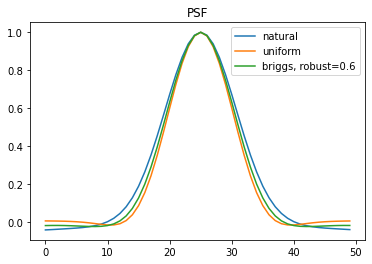

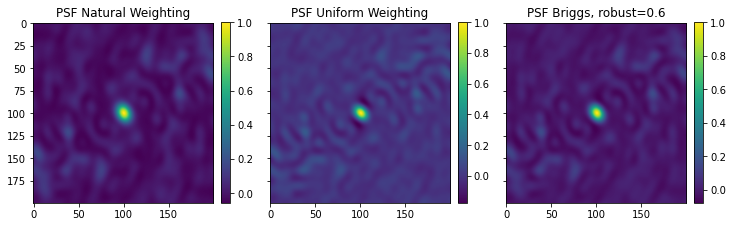

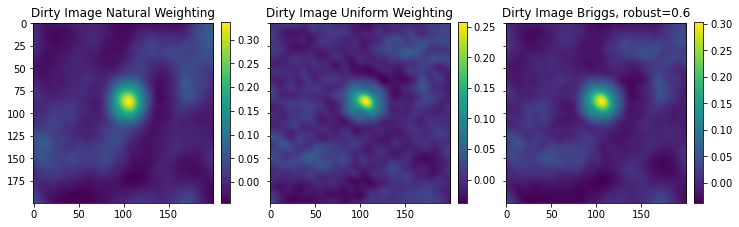

In [86]:
import xarray as xr

img_xds = xr.open_zarr('twhya_standard_gridder_lsrk_mfs.img.zarr')

## Plot PSF images
plt.figure()
plt.plot(img_xds.PSF_NAT[100,75:125,0,0,0],label='natural')
plt.plot(img_xds.PSF_UNI[100,75:125,0,0,0],label='uniform')
plt.plot(img_xds.PSF_BRG[100,75:125,0,0,0],label='briggs, robust='+str(imaging_weights_parms['robust']))
plt.legend()
plt.title('PSF')
plt.show()

fig0, ax0 = plt.subplots(1, 3, sharey=True,figsize=(12, 5))
im0 = ax0[0].imshow(img_xds.PSF_NAT[:,:,0,0,0])
im1 = ax0[1].imshow(img_xds.PSF_UNI[:,:,0,0,0])
im2 = ax0[2].imshow(img_xds.PSF_BRG[:,:,0,0,0])
ax0[0].title.set_text('PSF Natural Weighting')
ax0[1].title.set_text('PSF Uniform Weighting')
ax0[2].title.set_text('PSF Briggs, robust='+str(imaging_weights_parms['robust']))
fig0.colorbar(im0, ax=ax0[0], fraction=0.046, pad=0.04)
fig0.colorbar(im1, ax=ax0[1], fraction=0.046, pad=0.04)
fig0.colorbar(im2, ax=ax0[2], fraction=0.046, pad=0.04)
plt.show()

fig0, ax0 = plt.subplots(1, 3, sharey=True,figsize=(12, 5))
im0 = ax0[0].imshow(img_xds.IMAGE_NAT[:,:,0,0,0])
im1 = ax0[1].imshow(img_xds.IMAGE_UNI[:,:,0,0,0])
im2 = ax0[2].imshow(img_xds.IMAGE_BRG[:,:,0,0,0])
ax0[0].title.set_text('Dirty Image Natural Weighting')
ax0[1].title.set_text('Dirty Image Uniform Weighting')
ax0[2].title.set_text('Dirty Image Briggs, robust='+str(imaging_weights_parms['robust']))
fig0.colorbar(im0, ax=ax0[0], fraction=0.046, pad=0.04)
fig0.colorbar(im1, ax=ax0[1], fraction=0.046, pad=0.04)
fig0.colorbar(im2, ax=ax0[2], fraction=0.046, pad=0.04)
plt.show()